In [1]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import matplotlib.pyplot as plt


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """
    # Sigma correlates to the perplexity
    # Compute P-row and corresponding perplexity
    # Sigma = 1/sqrt(beta)
    P = np.exp(-D.copy() * beta) #array
    sumP = sum(P) #number
    
    H = np.log(sumP) + beta * np.sum(D * P) / sumP # number
    P = P / sumP #array
    return H, P

##Beta is just another value that regulates perplexity, so this function just calculates the perplexity of a single dot (instance)
##Returns the pij of each point?


In [2]:
H,P = Hbeta(np.array([[1,2,3,4,5],[6, 7, 8, 9, 10], [11, 12, 13, 14, 15]]))
print(H)
print(P)

[  1.49254081   4.76381204  15.37433102  45.93499377 130.72576981]
[[9.93262357e-01 9.93262357e-01 9.93262357e-01 9.93262357e-01
  9.93262357e-01]
 [6.69254912e-03 6.69254912e-03 6.69254912e-03 6.69254912e-03
  6.69254912e-03]
 [4.50940412e-05 4.50940412e-05 4.50940412e-05 4.50940412e-05
  4.50940412e-05]]


In [81]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n)) # Starts with 0
    beta = np.ones((n, 1)) # Value that passes to hbeta
    logU = np.log(perplexity) 

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] # slice of X with actual values in 2D
        
        (H, thisP) = Hbeta(Di, beta[i]) #H=Perplexity, thisP = This row pij

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU # Calculated perplexity with beta - log of perplex input by user
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
         # If the difference is lower than 1e-5 we dont change perplexity stays as it is, if the difference is higher and less
         # than 50 times revaluated then increase or decrease precision
            if Hdiff > 0:  # This is the binary search because its moving beta by 2*n until it gets the desired perplexity
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values with new beta
            (H, thisP) = Hbeta(Di, beta[i]) 
            Hdiff = H - logU 
            tries += 1 #Tries the revaluation again

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
        if(i == 100):
            print(P)
        

    # Return final P-matrix
    # Sigma = 1/sqrt(beta)
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


In [59]:
P = x2p(np.array([[1,2,3,4,5], [6,7,8,9,10], [11, 12, 13, 14, 15]]))
print("P:", P)

Computing pairwise distances...
Computing P-values for point 0 of 3...
Mean value of sigma: 33554432.000000
P: [[0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]


In [3]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1)) #Restarle la mediana a todo
    (l, M) = np.linalg.eig(np.dot(X.T, X))

    #arr = np.array([[0,1,2,3,4],[5,6,7,8,9]])
    #print(arr)
    #print(arr.T)

    #bprint(np.dot(arr.T,arr))

    # print(np.dot(X.T, X).shape)

    Y = np.dot(X, M[:, 0:no_dims])
    
    return Y #Returns a new array with less dimensions


In [14]:
a = np.array([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12], [13, 14, 15, 16]])
print(a)
pca(a, 4)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
Preprocessing the data using PCA...
[[-6. -6. -6. -6.]
 [-2. -2. -2. -2.]
 [ 2.  2.  2.  2.]
 [ 6.  6.  6.  6.]]
[ 0.00000000e+00  3.20000000e+02 -3.50324616e-46  5.39795408e-30]
[[-0.8660254  -0.5         0.8660254   0.6373872 ]
 [ 0.28867513 -0.5        -0.28867513 -0.7652232 ]
 [ 0.28867513 -0.5        -0.28867513  0.063918  ]
 [ 0.28867513 -0.5        -0.28867513  0.063918  ]]


array([[ 4.44089210e-16,  1.20000000e+01,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  4.00000000e+00, -2.22044605e-16,
         0.00000000e+00],
       [ 0.00000000e+00, -4.00000000e+00,  2.22044605e-16,
         0.00000000e+00],
       [-4.44089210e-16, -1.20000000e+01,  0.00000000e+00,
         0.00000000e+00]])

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
[[0.00000000e+00 1.07166970e-06 2.58921891e-10 ... 3.34053202e-08
  4.59711432e-08 1.18603453e-07]
 [1.47630100e-07 0.00000000e+00 1.10357503e-11 ... 7.93706754e-10
  3.67373641e-10 3.94251507e-08]
 [1.79877631e-10 2.12945916e-11 0.00000000e+00 ... 1.19632835e-08
  3.12459975e-06 1.03746750e-06]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 25

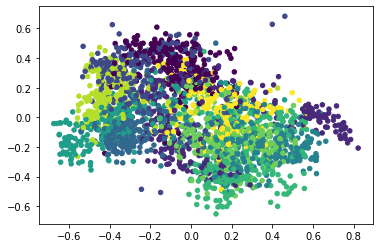

In [82]:
Y_1 = np.array([])
Y_2 = np.array([])
Y_3 = np.array([])

def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    
    X = pca(X, initial_dims).real #Real value, first impression of passing on to a 2d surface


    (n, d) = X.shape
    max_iter = 10
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims) #Random factor at the beggining
    with open('readme.txt', 'r') as f:
        for i in range(Y.shape[0]):
            line = f.readline().split()
            Y[i] = line
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))
    
    # Compute P-values
    P = x2p(X, 1e-5, perplexity) #Matrix of pij values
    P = P + np.transpose(P) # Just moving them around
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration from gradient Kullback-Leibler
    P = np.maximum(P, 1e-12)
    #
    # # Run iterations
    for iter in range(max_iter):
    #
    #     # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1) #Square of random number by row
        num = -2. * np.dot(Y, Y.T) # Square of randoms
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y)) # More randoms
        num[range(n), range(n)] = 0. # Establecer la diagonal principal a 0
        Q = num / np.sum(num) # The somewhat formula of qij
        Q = np.maximum(Q, 1e-12) # Make sure all of them sty above this level
    #
    #     # Compute gradient
        PQ = P - Q # Difference
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0) #With difference
            # if calculates the derivative of Y? 
    #
    #     # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + (gains * 0.8) * ((dY > 0.) == (iY > 0.)) # Sabe que es inicial
        # cuando iY == 0
        gains[gains < min_gain] = min_gain # Asegurarme min gain siempre sea ese valor que es el minimo del cambio
        iY = momentum * iY - eta * (gains * dY) # Valor que se va a ir moviendo
        Y = Y + iY #Empieza como random y se va actualizando con iy
        Y = Y - np.tile(np.mean(Y, 0), (n, 1)) # Restarle la mediana de una linea a todas las lineas
    
    #     # Compute current value of cost function
        if (iter + 1) % 5 == 0:
            C = np.sum(P * np.log(P / Q)) # Error value is calculated by this C
            print("Iteration %d: error is %f" % (iter + 1, C))
    #
    #     # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            
        if iter == 10:
            global Y_1
            Y_1 = Y
            
        if iter == 90:
            global Y_2
            Y_2 = Y
            
        if iter == 150:
            global Y_3
            Y_3 = Y
    #
     # Return solution
    return Y

print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
print("Running example on 2,500 MNIST digits...")
X = np.loadtxt("mnist2500_X.txt")

labels = np.loadtxt("mnist2500_labels.txt")
Y = tsne(X, 2, 50, 20.0)

plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
#plt.scatter(Y[:, 0], 0, 20, labels)
plt.show()

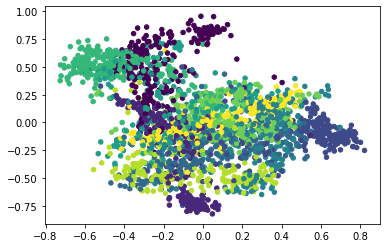

In [11]:
plt.scatter(Y_1[:, 0], Y_1[:, 1], 20, labels)
#plt.scatter(Y[:, 0], 0, 20, labels)
plt.show()

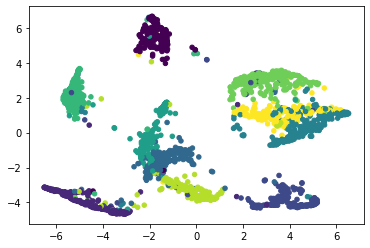

In [12]:
plt.scatter(Y_2[:, 0], Y_2[:, 1], 20, labels)
#plt.scatter(Y[:, 0], 0, 20, labels)
plt.show()

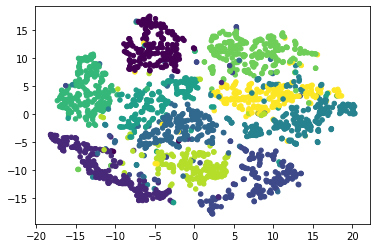

In [13]:
plt.scatter(Y_3[:, 0], Y_3[:, 1], 20, labels)
#plt.scatter(Y[:, 0], 0, 20, labels)
plt.show()

In [5]:
import numpy as np

x = np.array([[1,2,3,4,5],[6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])

print(np.maximum(x, 5))

[[ 5  5  5  5  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]]


In [6]:
x1 = np.arange(9.0).reshape((3, 3))

x2 = np.arange(3.0)

print(x1)
print(x2)

np.add(x1, x2)



[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[0. 1. 2.]


array([[ 0.,  2.,  4.],
       [ 3.,  5.,  7.],
       [ 6.,  8., 10.]])

In [16]:
print(ah) #num
print(ah.shape) 
ah[range(n_1), range(n_1)] = 0. #n_1 = n

[[0.         0.75711529 0.89831014 ... 0.72832432 0.71407839 0.67411293]
 [0.75711529 0.         0.70330572 ... 0.96768392 0.78263024 0.95772048]
 [0.89831014 0.70330572 0.         ... 0.74002048 0.85407877 0.58657885]
 ...
 [0.72832432 0.96768392 0.74002048 ... 0.         0.88027978 0.87689143]
 [0.71407839 0.78263024 0.85407877 ... 0.88027978 0.         0.64949346]
 [0.67411293 0.95772048 0.58657885 ... 0.87689143 0.64949346 0.        ]]
(2500, 2500)


In [51]:
np.tile(np.array([[1, 2]]), (2500, 1))

array([[1, 2],
       [1, 2],
       [1, 2],
       ...,
       [1, 2],
       [1, 2],
       [1, 2]])

In [34]:
x = np.array([[1,2]])

y = np.array([[1,2], [5,6], [7, 8]])

x-y

array([[ 0,  0],
       [-4, -4],
       [-6, -6]])

In [37]:
y[0, :]

array([1, 2])

In [39]:
a = np.array([[1,1], [1, 1], [1, 1]])

a+0.2

array([[1.2, 1.2],
       [1.2, 1.2],
       [1.2, 1.2]])

In [48]:
a = np.array([[1,2], [6, 2], [4, 5]])

a[a < 3] = 3

print(a)

[[3 3]
 [6 3]
 [4 5]]


In [59]:
with open('readme.txt', 'w') as f:
    for points in a:
        f.write(f'{points[0]} {points[1]}\n')

In [20]:
np.random.randn(2, 4)

array([[-0.02885913,  0.65139293, -0.73115368,  0.12509372],
       [ 0.89942979, -0.23876131, -0.77466985,  0.7525498 ]])

In [31]:
Y = np.array([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12], [13, 14, 15, 16]])
Z = np.array([[17,18,19,20], [21,22,23,24], [25, 26, 27, 28], [29, 30, 31, 32]])
print(Y)
print(Z)
sum_Y = np.sum(np.square(Y), 1) #rowise
print(sum_Y)
num = -2. * np.dot(Y, Y.T)
print(num)
print(np.add(num, sum_Y))

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
[[17 18 19 20]
 [21 22 23 24]
 [25 26 27 28]
 [29 30 31 32]]
[ 30 174 446 846]
[[  -60.  -140.  -220.  -300.]
 [ -140.  -348.  -556.  -764.]
 [ -220.  -556.  -892. -1228.]
 [ -300.  -764. -1228. -1692.]]
[[ -30.   34.  226.  546.]
 [-110. -174. -110.   82.]
 [-190. -382. -446. -382.]
 [-270. -590. -782. -846.]]


In [26]:
print(sum(Y, 0))

[12 15 18]


In [44]:
Y = np.array([[1,2,3,4], [5,6,7,8], [9, 10, 11, 12], [13, 14, 15, 16]])
Z = np.array([[17,18,19,20], [21,22,23,24], [25, 26, 27, 28], [29, 30, 31, 32]])
print(Y[:, 1] * Z[:, 1])
print(Y[:,1])
print(Z[:,1])

[ 36 132 260 420]
[ 2  6 10 14]
[18 22 26 30]


In [45]:
print(np.tile(Y[:,1] * Z[:, 1], (2,1)))

[[ 36 132 260 420]
 [ 36 132 260 420]]


In [57]:
AH = np.tile(Y[:,1] * Z[:, 1], (2,1)).T
print(np.tile(Y[:,1] * Z[:, 1], (2,1)).T)

[[ 36  36]
 [132 132]
 [260 260]
 [420 420]]


In [59]:
#A = np.array([[33,34,35,36], [37,38,39,40], [41, 42, 43, 44], [45, 46, 47, 48]])
A = np.array([[33,34], [37,38], [41, 42], [45, 46]])
print(A)
A[1, :] - A

[[33 34]
 [37 38]
 [41 42]
 [45 46]]


array([[ 4,  4],
       [ 0,  0],
       [-4, -4],
       [-8, -8]])

In [63]:
B = np.ones((4,2))
for j in range(4):
    for r in range(2):
        B[j,r] = A[1,r] - A[j,r]
B

array([[ 4.,  4.],
       [ 0.,  0.],
       [-4., -4.],
       [-8., -8.]])

In [64]:
AH * B

array([[  144.,   144.],
       [    0.,     0.],
       [-1040., -1040.],
       [-3360., -3360.]])

In [70]:
dy = np.zeros((4,2))
for i in range(4):
    dy[i, :] = np.sum(AH * B, 0)
dy

array([[-4256., -4256.],
       [-4256., -4256.],
       [-4256., -4256.],
       [-4256., -4256.]])

In [72]:
5*True

5

In [ ]:
gains = np.zeros((4,2))
